In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from typing import Dict, Text
import os, re, string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
import tensorflow as tf

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
MAX_FEATURES = 50000
MAX_SEQ_LENGTH = 1500
EMBED_DIM = 128

BATCH_SIZE = 64

In [3]:
stop_words = list(stopwords.words('english'))

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [5]:
strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
df_train = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")
df_test = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv")

In [7]:
len(df_train), len(df_test)

(900000, 478033)

In [8]:
df_train = df_train[['review_text', 'rating']]
df_train.isna().sum()

df_test = df_test[['review_text', 'review_id']]

In [9]:
X, y = df_train['review_text'], df_train['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [10]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    txt_data = tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')
    # Replace stop words
    if len(stop_words):
        for i in stop_words:
            txt_data = tf.strings.regex_replace(txt_data, f' {i} ', " ")

    # Replace spam keywords
    txt_data = tf.strings.regex_replace(txt_data, '\xa0', ' ')
    txt_data = tf.strings.regex_replace(txt_data, '\u200b', ' ')
    txt_data = tf.strings.regex_replace(txt_data, '\u200d', ' ')

    return txt_data

print("Initiating Vectorize Layer")
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LENGTH)
vectorize_layer.adapt(X_train)

Initiating Vectorize Layer


In [11]:
enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
enc.fit(np.array(y).reshape(-1, 1))

y_train_encoded = enc.transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = enc.transform(np.array(y_test).reshape(-1, 1))

In [12]:
def create_model1():
    inputs = tf.keras.layers.Input(name="text_xf", shape=(), dtype=tf.string)
    x = vectorize_layer(inputs)
    x = tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=EMBED_DIM, mask_zero=True)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dense(6, activation="softmax")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

def create_model():
    inputs = tf.keras.layers.Input(name="text_xf", shape=(), dtype=tf.string)
    x = vectorize_layer(inputs)
    layer = tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=EMBED_DIM, mask_zero=True)(x)
    layer = tf.keras.layers.LSTM(64)(layer)
    layer = tf.keras.layers.Dense(256,name='FC1')(layer)
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.Dropout(0.5)(layer)
    layer = tf.keras.layers.Dense(6,name='out_layer', activation="softmax")(layer)
    model = tf.keras.Model(inputs=inputs,outputs=layer)
    
    return model

In [13]:
with strategy.scope():

    model = create_model()
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_xf (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 1500)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1500, 128)         6400000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                             

In [14]:
# Initialize the Callbacks
early_stop = callbacks.EarlyStopping(patience = 5, restore_best_weights = True, verbose = 1)
reduce_lr = callbacks.ReduceLROnPlateau(factor = 0.1, patience = 2, mode = 'min', verbose = 1)


h = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    batch_size=BATCH_SIZE,
    epochs=2,
    shuffle=True,
    callbacks = [early_stop, reduce_lr]
)

Epoch 1/2
10547/10547 [==============================] - 995s 93ms/step - loss: 1.1150 - accuracy: 0.5249 - val_loss: 1.0258 - val_accuracy: 0.5626 - lr: 0.0010
Epoch 2/2
10547/10547 [==============================] - 802s 76ms/step - loss: 0.9640 - accuracy: 0.5923 - val_loss: 0.9622 - val_accuracy: 0.5914 - lr: 0.0010


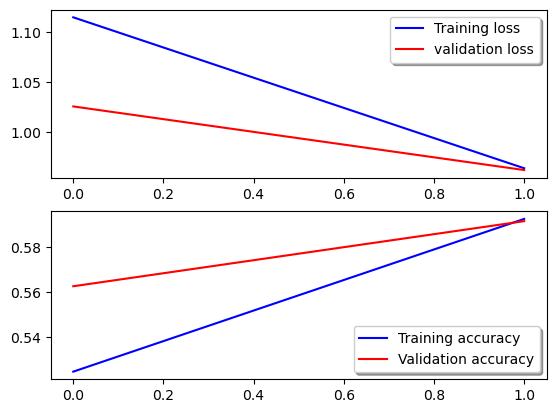

In [15]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(h.history['loss'], color='b', label="Training loss")
ax[0].plot(h.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(h.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(h.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
ypred = model.predict(X_test)
ypred = [np.argmax(i) for i in ypred]

y_org_test = [np.argmax(i) for i in y_test_encoded]

7032/7032 [==============================] - 151s 21ms/step


In [17]:
print(classification_report(y_org_test, ypred))

              precision    recall  f1-score   support

           0       0.60      0.35      0.44      7747
           1       0.57      0.24      0.34      7179
           2       0.49      0.48      0.48     18157
           3       0.56      0.54      0.55     47243
           4       0.58      0.58      0.58     78422
           5       0.65      0.75      0.69     66252

    accuracy                           0.59    225000
   macro avg       0.57      0.49      0.51    225000
weighted avg       0.59      0.59      0.59    225000



In [18]:
df_test = df_test[['review_text', 'review_id']]

In [19]:
ypred_test = model.predict(df_test['review_text'])
ypred_test = [np.argmax(i) for i in ypred_test]

14939/14939 [==============================] - 322s 22ms/step


In [20]:
df_test['rating'] = ypred_test
del df_test['review_text']

df_test.head(5)

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,5
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,5
3,8a46df0bb997269d6834f9437a4b0a77,3
4,d11d3091e22f1cf3cb865598de197599,3


In [21]:
df_test.to_csv("submission.csv", index=False)